## Jana Köhler, Martin Krück & Martin Iniguez de Onzono

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from scipy.linalg import fractional_matrix_power

# Exercise H5.1 Cross-Validation

## a) Preprocessing

In [2]:
# Defining the sphering function
def sphering(x_set):
    dim=x_set.shape[0]
    x_centrum = np.mean(x_set,axis=0)
    x_centered = x_set - x_centrum

    cov = x_centered.T @ x_centered / dim
    e_values, e_vectors = np.linalg.eigh(cov)
    e_val_mat = np.sqrt(np.linalg.inv(np.diag(e_values)))

    x_sphere = x_centered @ e_vectors @ e_val_mat.T

    return x_sphere,x_centrum,e_val_mat,e_vectors

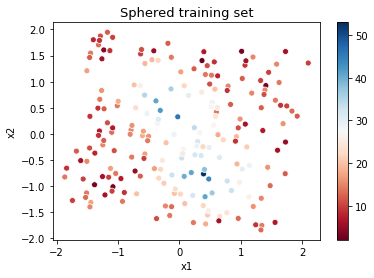

In [3]:
# Loading training set data
train_set = pd.read_csv("TrainingRidge.csv", delimiter=",")
x_train=np.array(train_set[['x1','x2']])
y_train=np.array(train_set['obs'])

# Sphering training set data and storing the matrices involved in the process
sph_train,mean_train,e_val_mat,e_vectors=sphering(x_train)

# Defining a Data Frame with the data from the sphered training set
data= {'x1': sph_train[:,0],'x2': sph_train[:,1],} 
d_train=pd.DataFrame(data)
d_train['obs']=y_train

# Plotting sphered training set
ax=sn.scatterplot(data=d_train,x='x1',y='x2',hue='obs',palette='RdBu');
norm = plt.Normalize(d_train['obs'].min(), d_train['obs'].max())
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])

ax.set_title('Sphered training set',fontsize=13)
ax.get_legend().remove()
ax.figure.colorbar(sm);

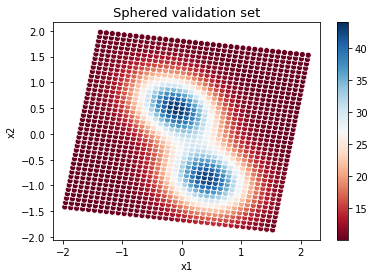

In [4]:
# Loading validation set data
valid_set = pd.read_csv("ValidationRidge.csv", delimiter=",")
x_val=np.array(valid_set[['x1','x2']])
y_val=np.array(valid_set['dens'])

# Sphering validation set data with the sphering matrices from the training set
x_val_centered = x_val - mean_train
sph_val = x_val_centered @ e_vectors @ e_val_mat.T

# Defining a Data Frame with the data from the sphered validation set
data= {'x1': sph_val[:,0],'x2': sph_val[:,1],} 
d_val=pd.DataFrame(data)
d_val['dens']=y_val

# Plotting sphered validation set
ax=sn.scatterplot(data=d_val,x='x1',y='x2',hue='dens' ,palette='RdBu');
norm = plt.Normalize(d_val['dens'].min(), d_val['dens'].max())
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])

ax.set_title('Sphered validation set',fontsize=13)
ax.get_legend().remove()
ax.figure.colorbar(sm);

## b) Monomials approach initialization

In [5]:
# Defining the function to synthesize monomials from an input set and a parameter "d"=num
def monomials(x_set,num):
    dim=x_set.shape[0]
    monom = np.zeros((num,dim))
    exponents = np.zeros((num,2))
    l = 0
    count = 0
    d = 0
    while count<=num and d<num:
        m = 0
        l= count
        while l>=0 and d<num:
            exponents[d,:] =[l,m]
            monom[d,:] = (x_set[:,0]**l)*(x_set[:,1]**m)
            m += 1
            l -= 1
            d += 1
        count += 1    
    return monom,exponents

### i) Visualize the 10 first monomials of the validation set

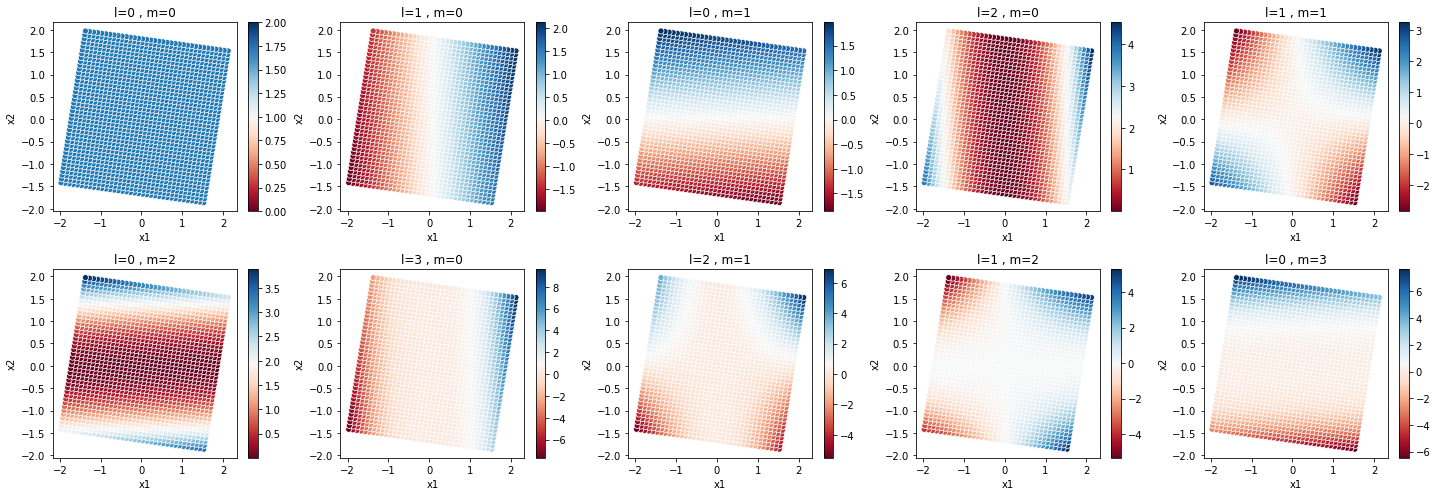

In [6]:
num=10
monom,exp=monomials(sph_val,num)

fig=plt.figure(figsize=(20,7))

# Plotting and storing all the monomials
for i in np.arange(num):
    ax1 = fig.add_subplot(2,5,i+1)
    d_val['monom' + str(i)]=monom[i,:]
       
    if i!=0:
        ax=sn.scatterplot(data=d_val,x='x1',y='x2',hue='monom' + str(i),palette='RdBu');
        norm = plt.Normalize(d_val['monom' + str(i)].min(), d_val['monom' +  str(i)].max())
        sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
        sm.set_array([])
        
        ax.set_title('l=' + str(np.int(exp[i,0])) + ' , m='+  str(np.int(exp[i,1])),fontsize=12)
        ax.get_legend().remove()
        ax.figure.colorbar(sm)
    else:
        ax=sn.scatterplot(data=d_val,x='x1',y='x2',hue='monom' + str(i));
        norm = plt.Normalize(0, 2)
        sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
        sm.set_array([])
        
        ax.set_title('l=0 , m=0' ,fontsize=12)
        
        ax.get_legend().remove()
        ax.figure.colorbar(sm)
        
fig.tight_layout() 

### ii) Plot the predicted function of y

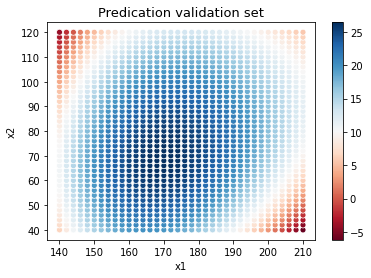

In [7]:
# Now we are producing the predicted function
num=10
monom,exp=monomials(sph_val,num)

# Performing the weights computation with the monomials from the validation dataset
w_val = np.linalg.inv(monom @ monom.T) @ monom @ y_val.T

# Performing the y prediction with those weights
y_pred_val = w_val @ monom
valid_set['y_pred']=y_pred_val

# Plotting the data prediction on the sphered validation set.
ax=sn.scatterplot(data=valid_set,x='x1',y='x2',hue='y_pred' ,palette='RdBu');
norm = plt.Normalize(valid_set['y_pred'].min(), valid_set['y_pred'].max())
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])

ax.set_title('Predication validation set',fontsize=13)
ax.get_legend().remove()
ax.figure.colorbar(sm);

## c) Regularization and n-cross validation

In [8]:
# Define the n-cross validation function
def n_cross_validation(n,x_set,y_set,lambdas,num):
    dim_set = x_set.shape[0]
    dim_lamb = len(lambdas)
    error = np.zeros((dim_lamb,n))
    chunk=np.int(dim_set/n)

    index=np.random.permutation(np.arange(dim_set,dtype=int))

    for j in range(0,n):

        in_set=index[j*chunk:(j+1)*chunk]
        in_train = index[(j+1)*chunk:dim_set]

        if j!=0:
            in_train=np.concatenate((index[0:((j)*chunk)],in_train))

        x_test= x_set[in_set,:]
        y_test=y_set[in_set]

        x_train_cros = x_set[in_train,:]
        y_train_cros = y_set[in_train]

        w = np.zeros((dim_lamb,num))

        monom_train,exp=monomials(x_train_cros,num)
        monom_test,exp=monomials(x_test,num)

        for i in range(0,dim_lamb):
            w[i,:] = np.linalg.inv(monom_train @ monom_train.T+ lambdas[i]*np.identity(num)) @ monom_train @ y_train_cros.T
            error[i,j] = sum((y_test - w[i,:] @ monom_test)**2)/len(y_test)

    return error

### i) Plot the MSE over the test set

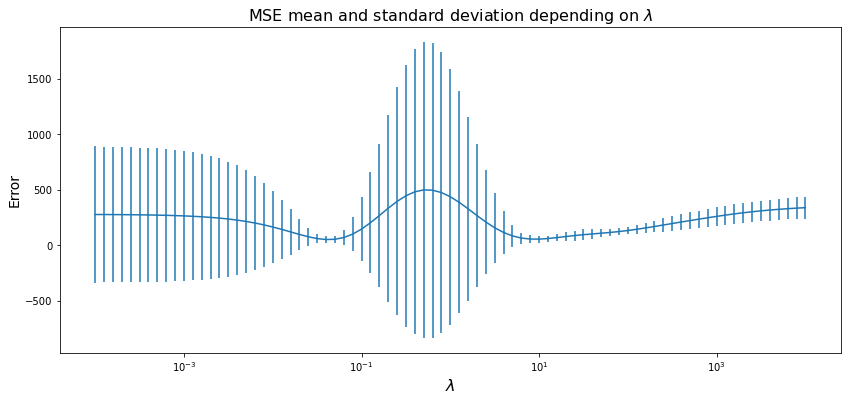

In [9]:
lambdas = 10**np.arange(-4,4.1,0.1)
n=10
num=55

# We get the error for every lambda and n iteration
error=n_cross_validation(n,sph_train,y_train,lambdas,num)
mse_error=np.mean(error,axis=1)
variance_error=np.std(error,axis=1)

# Plotting the error-bar plot
fig= plt.figure(figsize=(14,6))

plt.title(r'MSE mean and standard deviation depending on $\lambda$',fontsize=16)
plt.errorbar(lambdas,mse_error,yerr=variance_error)
plt.xscale('log')
plt.xlabel(r'$\lambda$',fontsize=16)
plt.ylabel('Error',fontsize=14);

### ii) Identify the regularization coefficient for training set with lower MSE

In [10]:
optim_in = np.argmin(mse_error)
print('The regularization coefficient with the minimal average MSE is: ' +str(round(lambdas[optim_in],2)) +'.')

The regularization coefficient with the minimal average MSE is: 0.04.


 ### iii) Train the model using the entire original training set with the obtained optimal coefficient

The MSE of the model on the validation set is 0.0068.


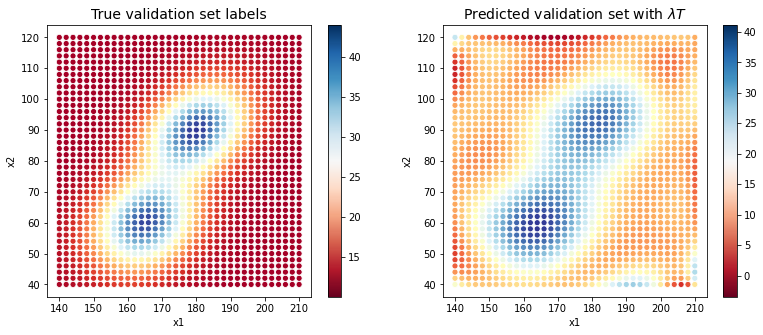

In [11]:
num=55
monom_final,exp=monomials(sph_train,num)
monom_val,exp=monomials(sph_val,num)

# Obtaining the weights using the parameter lambda T
w_opt_t = np.linalg.inv(monom_final @ monom_final.T+ lambdas[optim_in]*np.identity(num)) @ monom_final @ y_train.T

# Obtainig the predicted validation set with those weights
y_predicted_t = w_opt_t @ monom_val
valid_set['pred_T']=y_predicted_t

# Calculating the MSE error between both vectors
mse_y_val_t = np.mean(((y_predicted_t-y_val)**2)/len(y_val))
print('The MSE of the model on the validation set is ' + str(round(mse_y_val_t,4)) +'.')

# Plotting both validation set and its prediction
fig=plt.figure(figsize=(13,5))

fig.add_subplot(1,2,1)
ax=sn.scatterplot(data=valid_set,x='x1',y='x2',hue='dens' ,palette='RdYlBu');
norm = plt.Normalize(valid_set['dens'].min(), valid_set['dens'].max())
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])

ax.set_title('True validation set labels',fontsize=14)
ax.get_legend().remove()
ax.figure.colorbar(sm);

fig.add_subplot(1,2,2)
ax=sn.scatterplot(data=valid_set,x='x1',y='x2',hue='pred_T' ,palette='RdYlBu');
norm = plt.Normalize(valid_set['pred_T'].min(), valid_set['pred_T'].max())
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])

ax.set_title('Predicted validation set with $\lambda T$',fontsize=14)
ax.get_legend().remove()
ax.figure.colorbar(sm);

## d) Reproduce the exercise c with the validation set to obtain the generalization coefficient

The regularization coefficient with the minimal average MSE is: 0.1259.
The MSE of the model on the validation set is 0.0062.


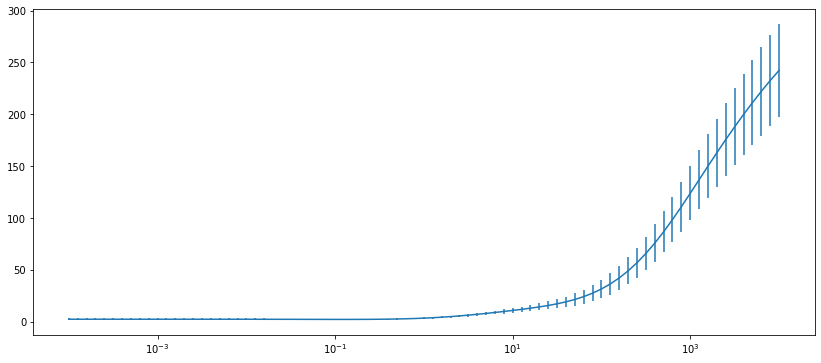

In [12]:
lambdas = 10**np.arange(-4,4.1,0.1)
n=10

# We get the error for every lambda and n iteration
error_val = n_cross_validation(n,sph_val,y_val,lambdas,num)
mse_error_val = np.mean(error_val,axis=1)
variance_error_val =np.std(error_val,axis=1)

# Plotting the error-bar plot
fig = plt.figure(figsize=(14,6))
plt.errorbar(lambdas,mse_error_val,yerr=variance_error_val)
plt.xscale('log')

# Obtaining the optimal regularization parameter
optim_in_val = np.argmin(mse_error_val)
print('The regularization coefficient with the minimal average MSE is: ' +str(round(lambdas[optim_in_val],4)) +'.')

# Obtaining the weights using the parameter lambda T
w_opt_g = np.linalg.inv(monom_final @ monom_final.T+ lambdas[optim_in_val]*np.identity(num)) @ monom_final @ y_train.T

# Obtainig the predicted validation set with those weights
y_predicted_G = w_opt_g @ monom_val
valid_set['pred_G']=y_predicted_G

# Calculating the MSE of the model
mse_y_val_g = np.mean(((y_predicted_G-y_val)**2)/len(y_val))
print('The MSE of the model on the validation set is ' + str(round(mse_y_val_g,4)) +'.')

## e) Are both lambdas different?

In [13]:
print('\u03BBG is ' + str(round(lambdas[optim_in_val],4)) +' and \u03BBT is ' + str(round(lambdas[optim_in],4)) + '.')

λG is 0.1259 and λT is 0.0398.


### i) Compare the plots of $\lambda$T and $\lambda$G on the training set

The MSE between both models is 0.002.


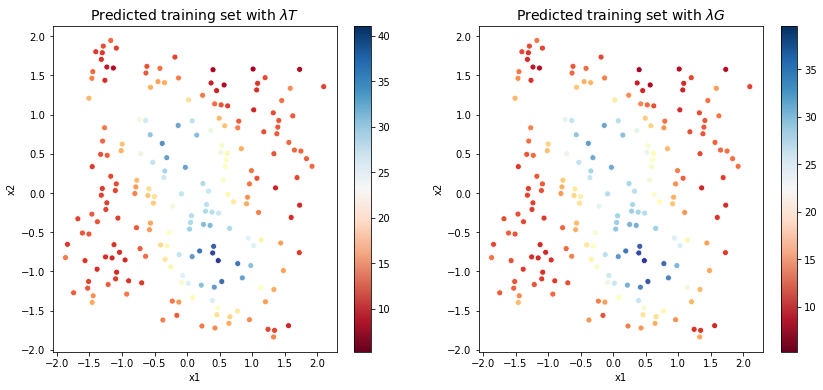

In [14]:
# Calculating the prediction of the training set using the weights with the lambda T parameter
y_predicted_train_t = w_opt_t @ monom_final
d_train['pred_lambda_t']=y_predicted_train_t

# Calculating the prediction of the training set using the weights with the lambda T parameter
y_predicted_train_g = w_opt_g @ monom_final
d_train['pred_lambda_g']=y_predicted_train_g

# Plotting both sets 
fig = plt.figure(figsize=(14,6))

fig.add_subplot(1,2,1)
ax=sn.scatterplot(data=d_train,x='x1',y='x2',hue='pred_lambda_t' ,palette='RdYlBu');
norm = plt.Normalize(d_train['pred_lambda_t'].min(), d_train['pred_lambda_t'].max())
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])

ax.set_title('Predicted training set with $\lambda T$',fontsize=14)
ax.get_legend().remove()
ax.figure.colorbar(sm);

fig.add_subplot(1,2,2)
ax=sn.scatterplot(data=d_train,x='x1',y='x2',hue='pred_lambda_g' ,palette='RdYlBu');
norm = plt.Normalize(d_train['pred_lambda_g'].min(), d_train['pred_lambda_g'].max())
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])

ax.set_title('Predicted training set with $\lambda G$',fontsize=14)
ax.get_legend().remove()
ax.figure.colorbar(sm);

mse_y_train_learned = np.mean(((y_predicted_train_t-y_predicted_train_g)**2)/len(y_predicted_train_t))
print('The MSE between both models is ' + str(round(mse_y_train_learned,3)) +'.')

### ii) Compare the plots of $\lambda$T and $\lambda$G on the validation set

The MSE between both models is 0.002.


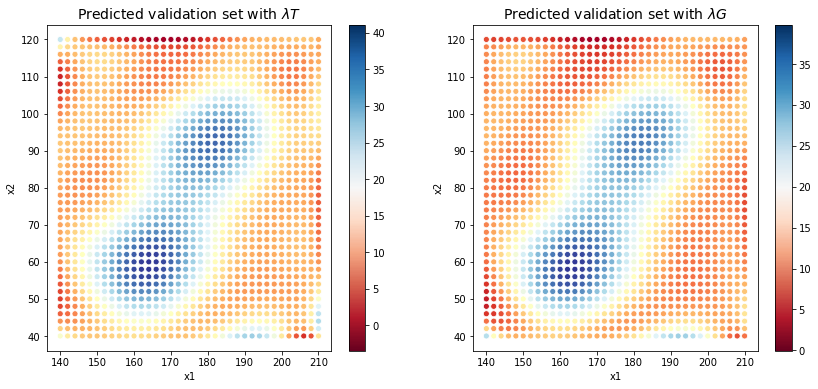

In [15]:
# Calculating the prediction of the validation set using the weights with the lambda T parameter
y_predicted_val_t = w_opt_t @ monom_val
valid_set['pred_val_t']=y_predicted_val_t

# Calculating the prediction of the validation set using the weights with the lambda G parameter
y_predicted_val_g = w_opt_g @ monom_val
valid_set['pred_val_g']=y_predicted_val_g

# Plotting both sets 

fig = plt.figure(figsize=(14,6))

fig.add_subplot(1,2,1)
ax=sn.scatterplot(data=valid_set,x='x1',y='x2',hue='pred_val_t' ,palette='RdYlBu');
norm = plt.Normalize(valid_set['pred_val_t'].min(), valid_set['pred_val_t'].max())
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])

ax.set_title('Predicted validation set with $\lambda T$',fontsize=14)
ax.get_legend().remove()
ax.figure.colorbar(sm);

fig.add_subplot(1,2,2)
ax=sn.scatterplot(data=valid_set,x='x1',y='x2',hue='pred_val_g' ,palette='RdYlBu');
norm = plt.Normalize(valid_set['pred_val_g'].min(), valid_set['pred_val_g'].max())
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])

ax.set_title('Predicted validation set with $\lambda G$',fontsize=14)
ax.get_legend().remove()
ax.figure.colorbar(sm);

mse_y_val_learned = np.mean(((y_predicted_val_t-y_predicted_val_g)**2)/len(y_predicted_val_t))
print('The MSE between both models is ' + str(round(mse_y_val_learned,3)) +'.')